In [1]:
import math
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from IPython.utils import io
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/
from motion.direct_transcription import motion_synthesize

/home/jeroen/repos/traffic-scheduling


### Setup

Lane between two intersections with capacity for a single waiting vehicle. We want to find out under what conditions a next vehicle can start entering the lane.

In [131]:
params = {
    'vmax': 1,       # full velocity at crossing
    'amax': 0.5,     # maximum acceleration/deceleration
    'L': 0.75,       # follow distance = vehicle length
    'W': 0.25,       # vehicle width
    'D': 5,          # length of lane
    'dt': 0.05,      # direct transcription time-step size
}
params['l'] = params['L']                     # follow distance
params['rho'] = params['L'] / params['vmax']  # follow time

# trick: make parameters directly accessible as variables
locals().update(params)

General helper quantities and functions and helper plotting functions.

In [132]:
def acceleration(t):
    return t*t * amax / 2

df = vmax / amax
acceleration_distance = acceleration(df)

ds = math.sqrt(L / amax)

p0 = -D # initial position
capacity = math.floor((D - W - 2 * acceleration_distance) / L)
pa = - 2 * acceleration_distance - (capacity - 1) * L

In [133]:
def draw_guiding_lines(intervals=None):
    # draw buffer positions
    for i in range(capacity):
        plt.axhline(y=- acceleration_distance - i * L, color='lightgrey', linestyle='--', lw=1)
    # deceleration for first waiting position
    plt.axhline(y=pa, color='lightgrey', linestyle='--', lw=1)
    # intersection v and w
    plt.axhline(y=p0, color='k', linestyle='--', lw=1)
    plt.axhline(y=0, color='k', linestyle='--', lw=1)

    if intervals is not None:
        for a, b in intervals:
            plt.axvline(x=a, color='lightgrey', linestyle='--', lw=1)
            plt.axvline(x=b, color='lightgrey', linestyle='--', lw=1)

### Direct transcription

In [134]:
def generate_tandem_trajectories(y, params):
    dt = params['dt']
    trajectories = []
    prev = None
    for start, end in y:
        yv = int(math.ceil(start / dt))
        yw = int(math.ceil(end / dt))

        if prev is not None:
            # extract the relevant steps from prev trajectory
            prev = prev[prev['t'] >= yv * dt]['x'].to_numpy()
        
        x = motion_synthesize(yw - yv + 1, prev=prev, **params)
        xd = pd.DataFrame(x, columns=['x'])
        xd['t'] = dt * np.array(range(yv, yw + 1))
        prev = xd.copy()
        trajectories.append(xd)
    return trajectories

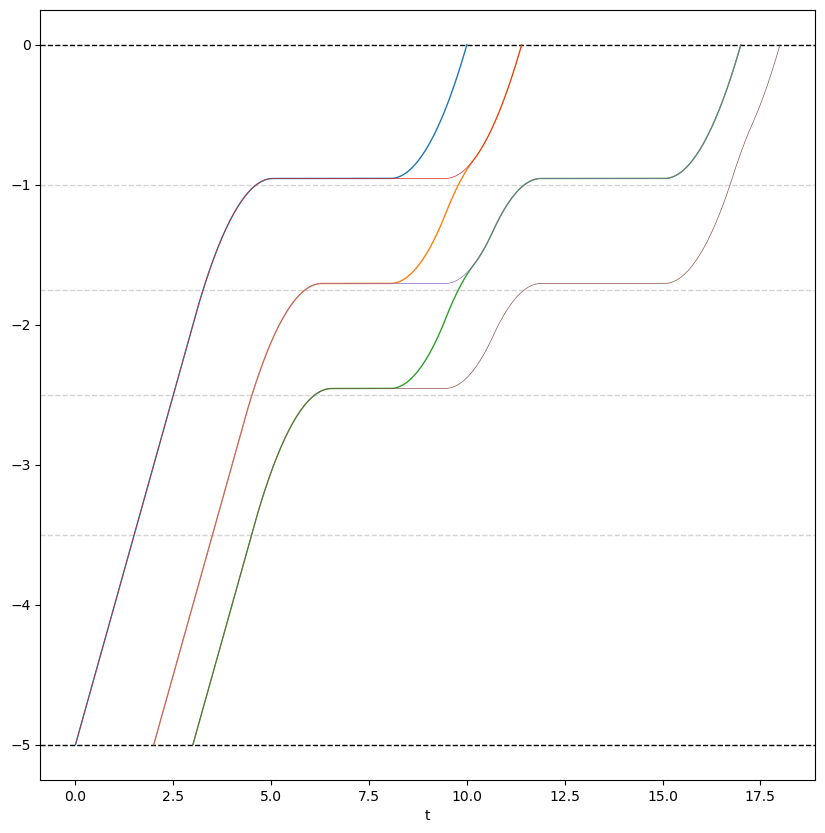

In [155]:
y = [[0, 10], [2, 11.4], [3, 17]]
y_alt = [[0, 11.4], [2, 17], [3, 18]]
with io.capture_output() as captured:
    trajectories = generate_tandem_trajectories(y, params)
    trajectories_alt = generate_tandem_trajectories(y_alt, params)

fig, ax = plt.subplots(figsize=(10,10))
draw_guiding_lines()
for trajectory in trajectories:
    trajectory.plot(x='t', y='x', legend=False, ax=ax, lw=1)
for trajectory in trajectories_alt:
    trajectory.plot(x='t', y='x', legend=False, ax=ax, lw=0.5)

Helper functions to integrate the control intervals into a trajectory for the direct method.

In [14]:
def interval_controller(amax, *intervals):
    def evaluate(t):
        a = 0
        for ix, i in enumerate(intervals):
            if i[0] <= t < i[1]:
                a = -amax if (ix % 2 == 0) else amax
        return a

    return evaluate

def double_integrator(control):
    return lambda t, y: (y[1], control(t))

### Figures for report

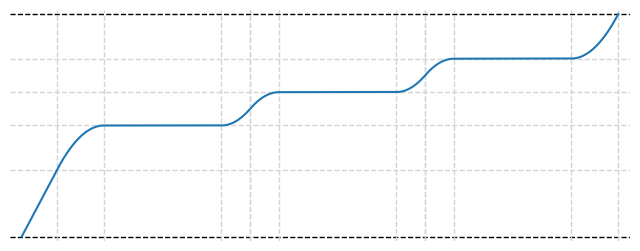

In [61]:
intervals = []

t_d = (pa - p0) / vmax
sn = [t_d + df + 5, t_d + df + 5 + 2 * ds + 5]
t_a = t_d + df + 5 + 2*ds + 5 + 2*ds + 5

# add initial deceleration interval
intervals.append([t_d, t_d + df])

# add start-stop intervals
for ts in sn:
    S = [[ts, ts+ds], [ts+ds, ts+2*ds]]
    intervals.extend(S)

# add final acceleration interval
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, t_a + df], [p0, vmax], max_step=0.001)
draw_guiding_lines(intervals)
plt.plot(tr.t, tr.y[0,:]);
ax = plt.gca()
ax.set_ylim([p0-0.1, 0.1])
ax.set_xlim([0 - 0.5, t_a + df + 0.5])
ax.axis('off')
plt.gcf().set_size_inches(8, 3)
plt.savefig('motion/tandem_trajectory.pdf')

### Experiments

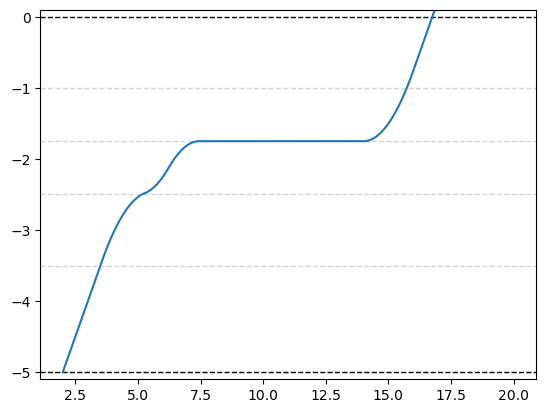

In [65]:
add = 2
t_d = (pa - p0) / vmax + add
s_1 = 5
t_a = 14

if t_d + df <= s_1:
    # separate
    intervals = [[t_d, t_d + df], [s_1, s_1 + ds], [s_1 + ds, s_1 + 2*ds]]
elif t_d >= s_1 + 2 * ds - df - 2 * acceleration(ds) / vmax:
    # merged
    intervals = [[s_1 + 2 * ds - df, s_1 + 2 * ds]]
else:
    # merging
    eps = (df - math.sqrt(df * (s_1 - t_d)))
    intervals = [[s_1 + 2 * eps - df, s_1 + eps],
                 [s_1 + eps, s_1 + ds],
                 [s_1 + ds, s_1 + 2 * ds]]

# final acceleration
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [add, 20], [p0, vmax], max_step=0.001)
draw_guiding_lines()
plt.plot(tr.t, tr.y[0,:]);
plt.gca().set_ylim([p0 - 0.1, 0 + 0.1]);

0.3252551286084109
0.2747448713915892
0.75


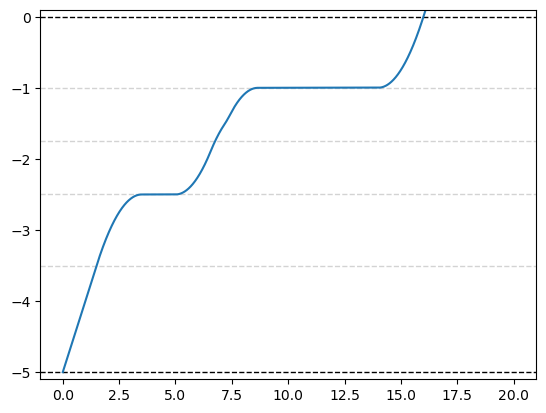

In [151]:
intervals = []

t_d = (pa - p0) / vmax
t_1 = 5
t_2 = 6.2
t_a = 14

# initial deceleration
intervals.append([t_d, t_d + df])

delta = L/amax / (t_2 - t_1) - ds + (t_2 - t_1) / 4
eps = (t_2 - t_1)/2 - delta

print(delta)
print(eps)
print(2 * acceleration(ds + delta) - 2 * acceleration(ds - eps))

intervals.extend([[t_1, t_1 + ds + delta],
                  [t_1 + ds + delta, t_1 + ds + delta + (delta + eps)],
                  [t_2 + ds - eps, t_2 + ds],
                  [t_2 + ds, t_2 + 2*ds]])

# final acceleration
intervals.append([t_a, t_a + df])

control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [p0, vmax], max_step=0.001)
draw_guiding_lines()
plt.plot(tr.t, tr.y[0,:]);
plt.gca().set_ylim([p0 - 0.1, 0 + 0.1]);